Analyzing Odds Data

    - In the last notebook, we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.

    - We saved that data to a file called 'df_bp3.csv'

    - In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)


In [2]:
df = pd.read_csv('df_bp3.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116079 entries, 0 to 116078
Columns: 199 entries, date to over_under_result
dtypes: float64(108), int64(12), object(79)
memory usage: 176.2+ MB


In [4]:
# checks to see if '0-probability' occurs in correct spots

pd.crosstab(df.implied_prob_h>0, df.season)

season,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1944,1938,1859,1943,1945,1934,1939,2103,2102,2099,2105,1394,2107,2109,2105,2103,2103,2105,2100,2106,2105,2104,2106,2269,1600,2017,2267,2266,2432,2428,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2429,898,2426,2430


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
110681,20200820,0,Thu,DET,AL,23,CHA,AL,26,0,9,51,D,NaN,NaN,NaN,CHI12,NaN,176.0,000000000,30110004x,32.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0,0.0,0.0,1.0,0.0,6.0,5.0,9.0,9.0,0.0,0.0,24.0,10.0,0.0,0.0,1.0,0.0,35.0,12.0,4.0,0.0,2.0,9.0,0.0,0.0,2.0,5.0,0.0,6.0,1.0,0.0,1.0,0.0,9.0,2.0,0.0,0.0,1.0,0.0,27.0,8.0,1.0,0.0,1.0,0.0,tosia901,Alex Tosi,conrc901,Chris Conroy,rackd901,David Rackley,barkl901,Lance Barksdale,NaN,(none),NaN,(none),gardr001,Ron Gardenhire,rentr001,Rich Renteria,gioll001,Lucas Giolito,turns003,Spencer Turnbull,NaN,(none),encae001,Edwin Encarnacion,turns003,Spencer Turnbull,gioll001,Lucas Giolito,candj002,Jeimer Candelario,3.0,jonej006,JaCoby Jones,8.0,cabrm001,Miguel Cabrera,10.0,schoj001,Jonathan Schoop,4.0,goodn002,Niko Goodrum,6.0,stewc002,Christin Stewart,7.0,maybc001,Cameron Maybin,9.0,romia002,Austin Romine,2.0,castw003,Willi Castro,5.0,andet001,Tim Anderson,6.0,moncy001,Yoan Moncada,5.0,abrej003,Jose Abreu,3.0,jimee001,Eloy Jimenez,7.0,encae001,Edwin Encarnacion,10.0,mazan001,Nomar Mazara,9.0,mccaj001,James McCann,2.0,mendd002,Danny Mendick,4.0,engea001,Adam Engel,8.0,NaN,Y,2020,9,1,9,202008200,0.260610,0.241027,0.306454,0.290198,0.417013,0.395370,0.723467,0.685568,47.0,53.0,27.0,17.0,108.0,106.0,0.263106,0.232863,0.317766,0.281398,0.460930,0.408266,0.778695,0.689664,7.0,10.0,5.0,1.0,14.0,15.0,0.615385,0.400000,0.607692,8.5,O
109057,20190623,0,Sun,TBA,AL,78,OAK,AL,80,8,2,54,D,NaN,NaN,NaN,OAK01,17006.0,178.0,003500000,010000100,39.0,15.0,3.0,0.0,1.0,8.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,8.0,4.0,1.0,1.0,0.0,0.0,27.0,7.0,1.0,0.0,0.0,0.0,33.0,6.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,6.0,4.0,8.0,8.0,1.0,0.0,27.0,14.0,0.0,1.0,3.0,0.0,reynj901,Jim Reynolds,sches901,Stu Scheurwater,wegnm901,Mark Wegner,rehaj901,Jeremie Rehak,NaN,(none),NaN,(none),cashk001,Kevin Cash,melvb001,Bob Melvin,yarbr001,Ryan Yarbrough,andeb004,Brett Anderson,NaN,(none)

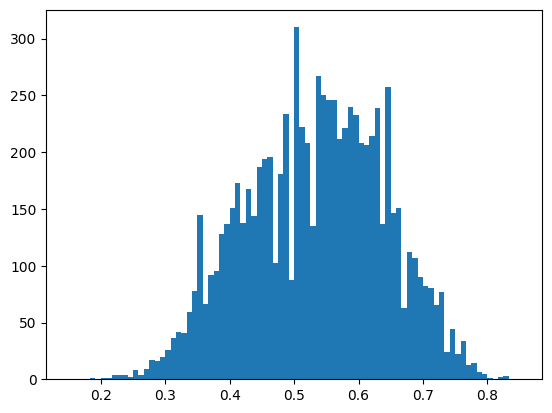

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,85));

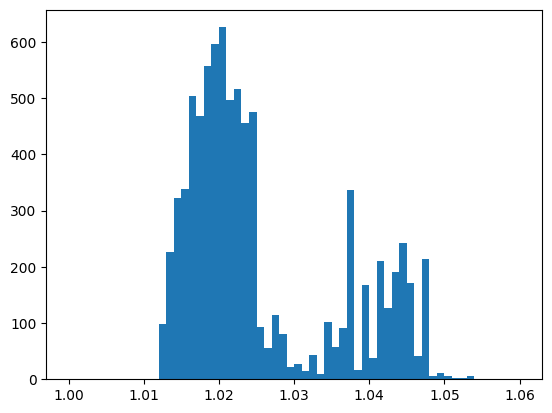

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

# interesting to see second peak around 1.04-1.05 ... IDEAS??

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()
X_train.shape, X_valid.shape, X_test.shape, 

((98617, 4), (10615, 4), (4856, 4))

In [12]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689617
[20]	valid_0's binary_logloss: 0.688621
[30]	valid_0's binary_logloss: 0.687796
[40]	valid_0's binary_logloss: 0.687222
[50]	valid_0's binary_logloss: 0.686696
[60]	valid_0's binary_logloss: 0.686315
[70]	valid_0's binary_logloss: 0.686004
[80]	valid_0's binary_logloss: 0.685771
[90]	valid_0's binary_logloss: 0.685617
[100]	valid_0's binary_logloss: 0.68542
[110]	valid_0's binary_logloss: 0.685303
[120]	valid_0's binary_logloss: 0.685201
[130]	valid_0's binary_logloss: 0.685073
[140]	valid_0's binary_logloss: 0.68496
[150]	valid_0's binary_logloss: 0.684864
[160]	valid_0's binary_logloss: 0.684815
[170]	valid_0's binary_logloss: 0.684751
[180]	valid_0's binary_logloss: 0.684722
[190]	valid_0's binary_logloss: 0.684729
[200]	valid_0's binary_logloss: 0.684765
[210]	valid_0's binary_logloss: 0.684777
[220]	valid_0's binary_logloss: 0.684806
[230]	valid_0's binary_logloss: 0.684807
Early s

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [13]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [14]:
hv_mean = y_train.mean()

In [15]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.683989640450657, 0.6905005746043794)

In [16]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6674197609198098

In [17]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.28209292110334905

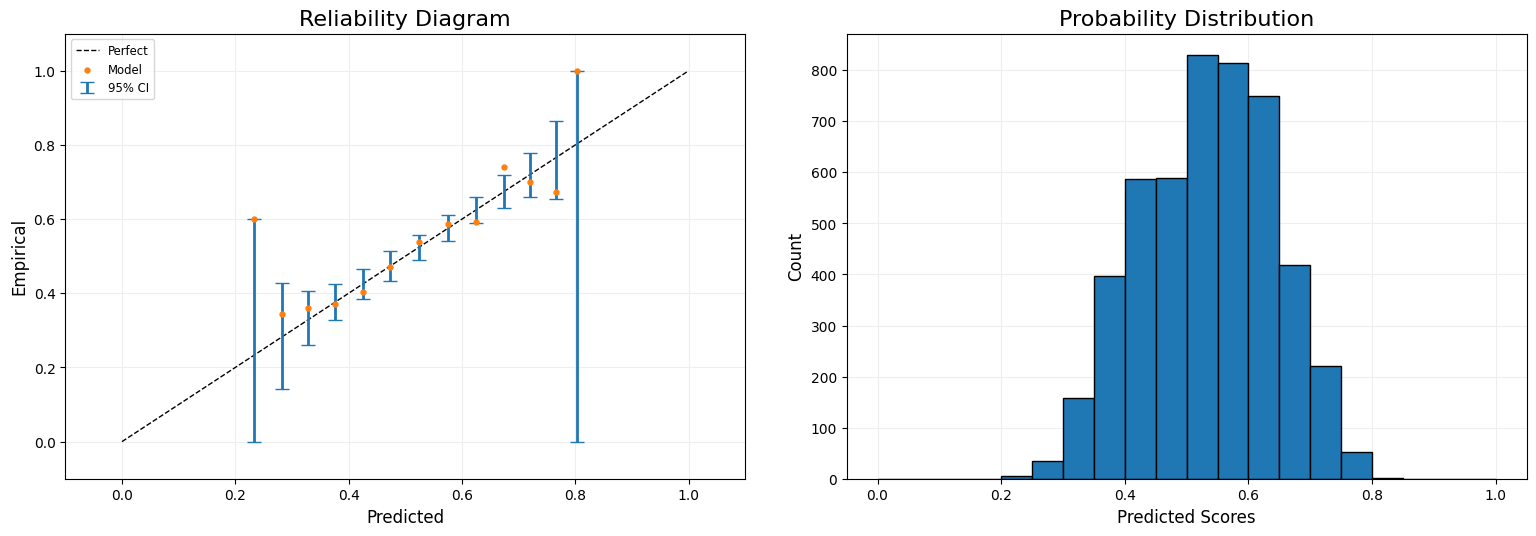

In [18]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

In [19]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

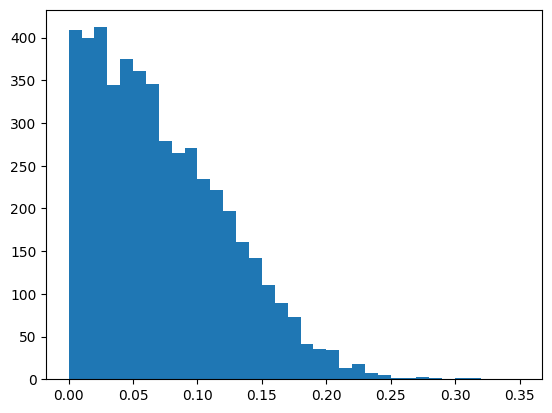

In [20]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [21]:
df_test[test_disc>0.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
113208,20210901,0,Wed,NYA,AL,133,ANA,AL,134,4,1,54,D,NaN,NaN,NaN,ANA01,28753.0,170.0,002100010,000001000,33.0,8.0,1.0,0.0,1.0,4.0,0.0,0.0,1.0,3.0,0.0,7.0,0.0,1.0,1.0,0.0,6.0,3.0,1.0,1.0,0.0,0.0,27.0,8.0,0.0,0.0,0.0,0.0,31.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,3.0,5.0,4.0,4.0,0.0,0.0,27.0,13.0,0.0,0.0,2.0,0.0,valej901,Junior Valentine,holbs901,Sam Holbrook,muchm901,Mike Muchlinski,wolfj901,Jim Wolf,NaN,(none),NaN,(none),boona001,Aaron Boone,maddj801,Joe Maddon,coleg001,Gerrit Cole,naugp001,Packy Naughton,chapa001,Aroldis Chapman,voitl001,Luke Voit,coleg001,Gerrit Cole,naugp001,Packy Naughton,lemad001,DJ LeMahieu,4.0,rizza001,Anthony Rizzo,3.0,judga001,Aaron Judge,9.0,voitl001,Luke Voit,10.0,gallj002,Joey Gallo,7.0,higak001,Kyle Higashioka,2.0,odorr001,Rougned Odor,5.0,velaa001,Andrew Velazquez,6.0,gardb001,Brett Gardner,8.0,fletd002,David Fletcher,4.0,ohtas001,Shohei Ohtani,10.0,gossp001,Phil Gosselin,5.0,walsj001,Jared Walsh,3.0,uptoj001,Justin Upton,7.0,marsb002,Brandon Marsh,8.0,stasm001,Max Stassi,2.0,adelj001,Jo Adell,9.0,mayfj001,Jack Mayfield,6.0,NaN,Y,2021,-3,0,5,202109010,0.253074,0.240195,0.314006,0.325054,0.424482,0.409645,0.738488,0.734700,75.0,70.0,27.0,17.0,94.0,110.0,0.226950,0.250501,0.292208,0.329148,0.355623,0.434870,0.647831,0.764018,23.0,20.0,8.0,4.0,11.0,20.0,0.294118,0.736842,0.278638,8.5,U
114570,20220614,0,Tue,ATL,NL,63,WAS,NL,64,10,4,54,N,NaN,NaN,NaN,WAS11,24490.0,194.0,115002001,003001000,39.0,13.0,1.0,0.0,5.0,9.0,0.0,1.0,1.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,8.0,3.0,4.0,4.0,1.0,0.0,27.0,7.0,0.0,0.0,0.0,0.0,33.0,7.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,4.0,4.0,10.0,10.0,1.0,0.0,27.0,6.0,0.0,0.0,0.0,0.0,wolcq901,Quinn Wolcott,porta901,Alan Porter,dejer901,Ramon De Jesus,becka901,Adam Beck,NaN,(none),NaN,(none),snitb801,Brian Snitker,martd002,Dave Martinez,friem001,Max Fried,tetrj001,Jackson Tetreault,stepj002,Jackson Stephens,

In [22]:
# 'Fancy' code that basically says, if the home team is favored then take select their SP. If not, select the oppo SP.

# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Gerrit Cole',
 'Max Fried',
 'Spencer Strider',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Sandy Alcantara']

In [23]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Packy Naughton',
 'Jackson Tetreault',
 'Erasmo Ramirez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'Anibal Sanchez']

In [24]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,2,32,5,3,7
1,3,11,4,10,10


In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.4,0.5,0.6
home_victory,,,
0,0,38,11
1,1,25,12


Analysis 

- LV odds are "better" than our current model
- Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
- LV probs seem to be "right" in those cases

CONCLUSION: Need to factor in the starting pitcher to improve our model!